# Week2 Genomic interval data - Locating genomic interval with corresponding DNA_symbol

### This week's goal is to find the annotated region from the genomic interval using the provided packages; further step is to integrate this method into the function built from week 1

## 1. Setting up

In [105]:
#import libraries

import os
import tarfile
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import pyranges as pr


In [4]:
# Mount google drive to co-lab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
cd /content/drive/MyDrive/Z.Chen/

/content/drive/MyDrive/Z.Chen


<Figure size 1400x1200 with 0 Axes>

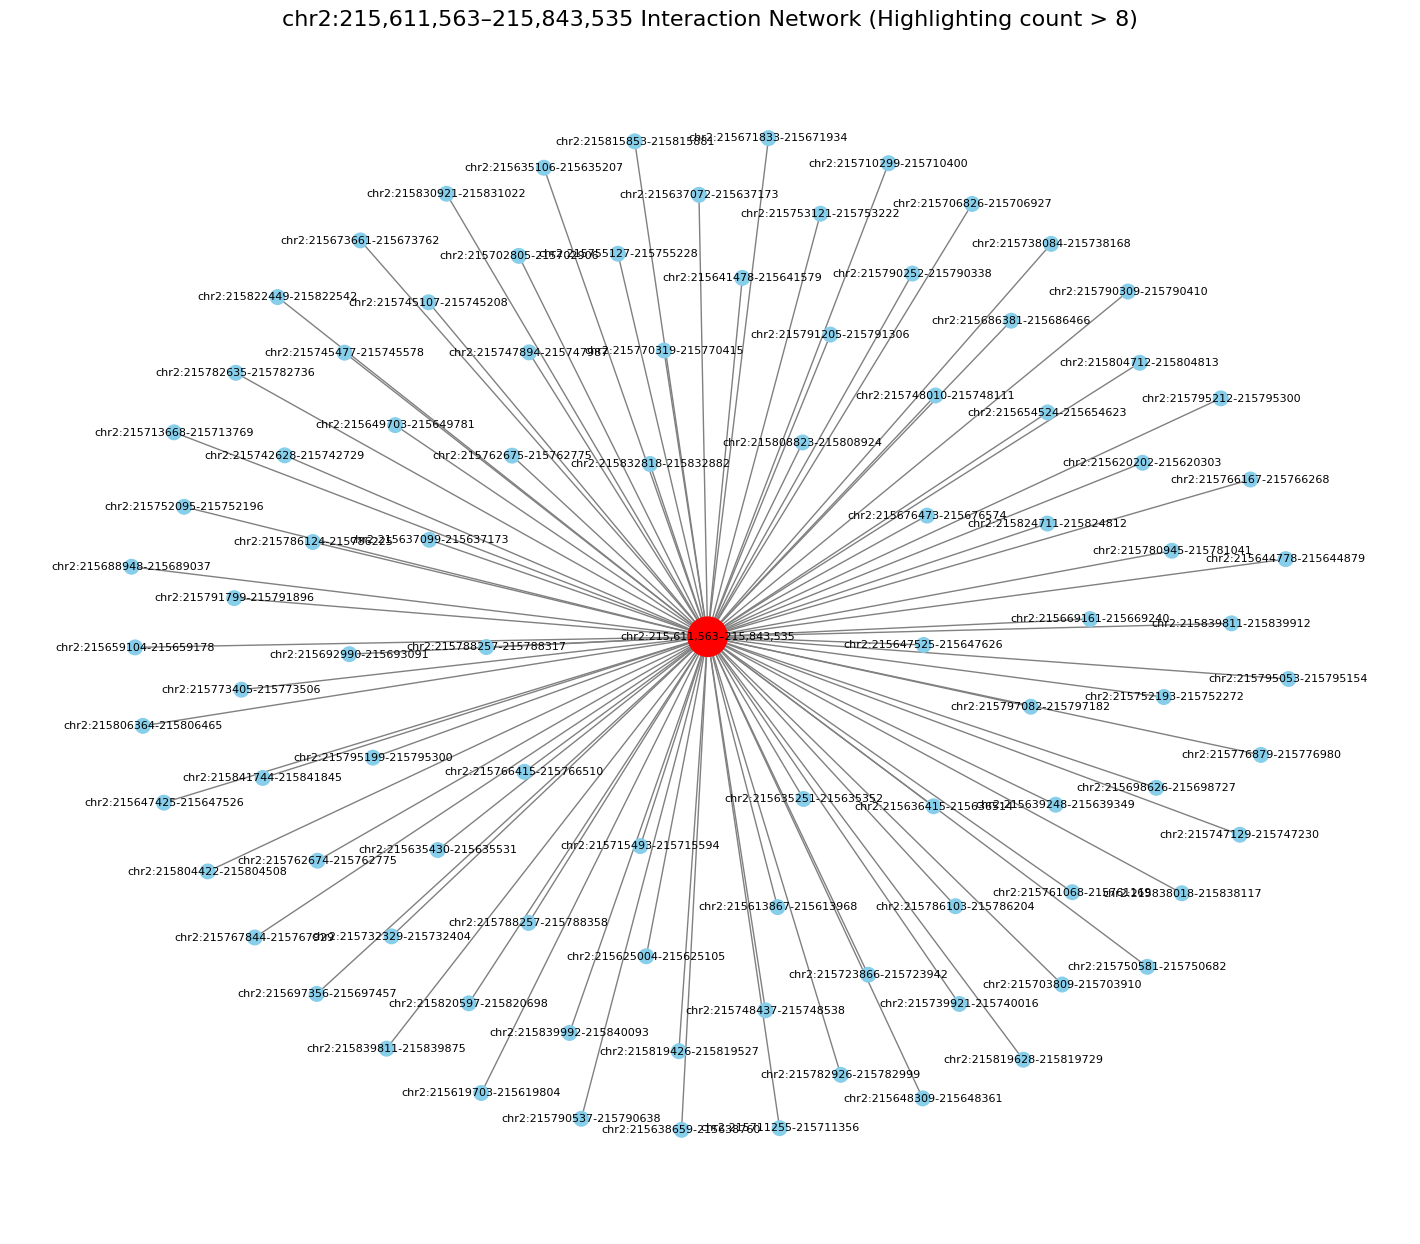

In [78]:
# Test function implemented from last week

from coexp import get_coexp_network
get_coexp_network('chr2:215,611,563–215,843,535', "./iMARGI_extracted/GSM4729222_HUVEC_control_2_iMARGI.bedpe.gz", 8 )

## 2. Exploring the differences in the given five iMARGI datasets

### five dataframes from iMARGI file varies in the avaialbility of pre-annodated gene names and gene data;
### Use dataset 9222 and 6840 as examples

In [79]:
df_9222 = pd.read_csv("./iMARGI_extracted/GSM4729222_HUVEC_control_2_iMARGI.bedpe.gz", sep='\t', comment='#', header=None)

In [80]:
df_6840 = pd.read_csv("./iMARGI_extracted/GSM4006840_HUVEC_control_iMARGI.bedpe.gz", sep='\t', comment='#', header=None)

In [81]:
# check preview
df_9222.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,1,+,-,ENSG00000066279|ASPM|protein_coding,.,ENSG00000066279|ASPM|protein_coding,.,147
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,1,-,-,ENSG00000166225|FRS2|protein_coding,.,ENSG00000141480|ARRB2|protein_coding,.,Inter-chromosome
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,1,-,-,ENSG00000137801|THBS1|protein_coding,.,ENSG00000153339|TRAPPC8|protein_coding,.,Inter-chromosome
3,chr17,21002150,21002214,chr17,21002150,21002214,K00180:743:H2TV7BBXY:6:1101:1205:44939,1,+,-,"ENSG00000124422|USP22|protein_coding,ENSG00000...",.,"ENSG00000124422|USP22|protein_coding,ENSG00000...",.,63
4,chr5,72197322,72197421,chr5,72197305,72197406,K00180:743:H2TV7BBXY:6:1101:1205:48667,1,-,+,ENSG00000131711|MAP1B|protein_coding,.,ENSG00000131711|MAP1B|protein_coding,.,83


In [82]:
df_6840.head(5)

,0,1,2,3,4,5,6,7,8,9
0,chr4,40944863,40944903,chr4,40944853,40944901,.,.,+,-
1,chr12,53043128,53043227,chr12,53043250,53043351,.,.,+,-
2,chr4,40924463,40924535,chr3,111255038,111255094,.,.,+,-
3,chr1,179100935,179101034,chr1,179100959,179101060,.,.,+,-
4,chr18,61758386,61758485,chr18,61758326,61758427,.,.,-,+


In [83]:
df_6840.columns = [
    "RNA_chr", "RNA_start", "RNA_end",
    "DNA_chr", "DNA_start", "DNA_end",
    "name", "score", "RNA_strand", "DNA_strand"
]

In [84]:
df_6840.head(5)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand
0,chr4,40944863,40944903,chr4,40944853,40944901,.,.,+,-
1,chr12,53043128,53043227,chr12,53043250,53043351,.,.,+,-
2,chr4,40924463,40924535,chr3,111255038,111255094,.,.,+,-
3,chr1,179100935,179101034,chr1,179100959,179101060,.,.,+,-
4,chr18,61758386,61758485,chr18,61758326,61758427,.,.,-,+


In [85]:
#drop columns with irrelevant information for df_9222; namely columns 7, 11, 13

df_9222.drop(df_9222.columns[[7, 11, 13]], axis=1, inplace=True)

In [86]:
#assign new column names

df_9222.columns = [
    "RNA_chr", "RNA_start", "RNA_end",
    "DNA_chr", "DNA_start", "DNA_end",
    "Read_ID", "RNA_strand", "DNA_strand",
    "RNA_gene_info", "DNA_gene_info","Frequency"
]

In [87]:
df_9222.head(4)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,Read_ID,RNA_strand,DNA_strand,RNA_gene_info,DNA_gene_info,Frequency
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,+,-,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding,147
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,-,-,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding,Inter-chromosome
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,-,-,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding,Inter-chromosome
3,chr17,21002150,21002214,chr17,21002150,21002214,K00180:743:H2TV7BBXY:6:1101:1205:44939,+,-,"ENSG00000124422|USP22|protein_coding,ENSG00000...","ENSG00000124422|USP22|protein_coding,ENSG00000...",63


I noticed that the additional information found in df_9222, specifically under the column names, 'RNA_gene_info' and 'DNA_gene_info', contain various meta data might have already included the gene names. Therefore, I decided to explore those two columns to see if I can annodate the gene names without consulting the R package tools first.

In [88]:
#counting the frequency of each number of the lenth of the info separated by '|'

df_9222['RNA_gene_info'].str.split('|').apply(len).value_counts()

,count
RNA_gene_info,
3,9684264
1,1456889
5,1296175
7,128613
9,22209
11,3940
39,481
45,432
41,226


In [89]:
# create the variable split_lengths to store the row index of desired number

split_lengths = df_9222['RNA_gene_info'].str.split('|').apply(len)

In [90]:
# define that any row with less or more than 3 entries is considered as 'bad_row' so that we focus on the majority of the data

bad_rows = df_9222[split_lengths != 3]
bad_rows.head(3)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,Read_ID,RNA_strand,DNA_strand,RNA_gene_info,DNA_gene_info,Frequency
3,chr17,21002150,21002214,chr17,21002150,21002214,K00180:743:H2TV7BBXY:6:1101:1205:44939,+,-,"ENSG00000124422|USP22|protein_coding,ENSG00000...","ENSG00000124422|USP22|protein_coding,ENSG00000...",63
11,chr3,98797620,98797719,chr3,176949607,176949695,K00180:743:H2TV7BBXY:6:1101:1215:48579,+,+,"ENSG00000064225|ST3GAL6|protein_coding,ENSG000...",.,78152074
14,chr10,32352460,32352498,chr10,32352458,32352497,K00180:743:H2TV7BBXY:6:1101:1225:5974,+,-,"ENSG00000120616|EPC1|protein_coding,ENSG000002...","ENSG00000120616|EPC1|protein_coding,ENSG000002...",36


In [91]:
# print an example of a bad_row with 39 entries

print(df_9222.loc[2951, 'RNA_gene_info'])

ENSG00000253910|PCDHGB2|protein_coding,ENSG00000253537|PCDHGA7|protein_coding,ENSG00000253159|PCDHGA12|protein_coding,ENSG00000253485|PCDHGA5|protein_coding,ENSG00000254221|PCDHGB1|protein_coding,ENSG00000081853|PCDHGA2|protein_coding,ENSG00000253305|PCDHGB6|protein_coding,ENSG00000254245|PCDHGA3|protein_coding,ENSG00000262576|PCDHGA4|protein_coding,ENSG00000253873|PCDHGA11|protein_coding,ENSG00000204956|PCDHGA1|protein_coding,ENSG00000261934|PCDHGA9|protein_coding,ENSG00000253767|PCDHGA8|protein_coding,ENSG00000253731|PCDHGA6|protein_coding,ENSG00000253846|PCDHGA10|protein_coding,ENSG00000262209|PCDHGB3|protein_coding,ENSG00000254122|PCDHGB7|protein_coding,ENSG00000276547|PCDHGB5|protein_coding,ENSG00000253953|PCDHGB4|protein_coding


In [92]:
df_9222[split_lengths == 39]['RNA_gene_info'].head()

,RNA_gene_info
2951,"ENSG00000253910|PCDHGB2|protein_coding,ENSG000..."
71838,"ENSG00000253910|PCDHGB2|protein_coding,ENSG000..."
104963,"ENSG00000253910|PCDHGB2|protein_coding,ENSG000..."
111432,"ENSG00000253910|PCDHGB2|protein_coding,ENSG000..."
137203,"ENSG00000253910|PCDHGB2|protein_coding,ENSG000..."


### Proceeding with split entries with exact 3

In [93]:
df_9222_good = df_9222[split_lengths == 3]

In [94]:
df_9222_good.head()

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,Read_ID,RNA_strand,DNA_strand,RNA_gene_info,DNA_gene_info,Frequency
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,+,-,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding,147
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,-,-,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding,Inter-chromosome
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,-,-,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding,Inter-chromosome
4,chr5,72197322,72197421,chr5,72197305,72197406,K00180:743:H2TV7BBXY:6:1101:1205:48667,-,+,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711|MAP1B|protein_coding,83
5,chr17,3734910,3735009,chr17,3735023,3735124,K00180:743:H2TV7BBXY:6:1101:1215:8312,+,-,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457|ITGAE|protein_coding,213


In [95]:
# Assign the RNA_gene_info into 3 new columns "gene_id", "gene_symbol", "gene_type"

df_9222_good[['RNA_gene_id', 'RNA_gene_symbol', 'RNA_gene_type']] = df_9222_good['RNA_gene_info'].str.split('|', expand=True)

/tmp/ipython-input-95-784198167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9222_good[['RNA_gene_id', 'RNA_gene_symbol', 'RNA_gene_type']] = df_9222_good['RNA_gene_info'].str.split('|', expand=True)
/tmp/ipython-input-95-784198167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9222_good[['RNA_gene_id', 'RNA_gene_symbol', 'RNA_gene_type']] = df_9222_good['RNA_gene_info'].str.split('|', expand=True)
/tmp/ipython-input-95-784198167.py:3: SettingWithCopyWarning: 
A value is trying to be set o

In [96]:
df_9222_good.head(5)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,Read_ID,RNA_strand,DNA_strand,RNA_gene_info,DNA_gene_info,Frequency,RNA_gene_id,RNA_gene_symbol,RNA_gene_type
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,+,-,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding,147,ENSG00000066279,ASPM,protein_coding
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,-,-,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding,Inter-chromosome,ENSG00000166225,FRS2,protein_coding
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,-,-,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding,Inter-chromosome,ENSG00000137801,THBS1,protein_coding
4,chr5,72197322,72197421,chr5,72197305,72197406,K00180:743:H2TV7BBXY:6:1101:1205:48667,-,+,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711|MAP1B|protein_coding,83,ENSG00000131711,MAP1B,protein_coding
5,chr17,3734910,3735009,chr17,3735023,3735124,K00180:743:H2TV7BBXY:6:1101:1215:8312,+,-,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457|ITGAE|protein_coding,213,ENSG00000083457,ITGAE,protein_coding


### Doing the same for "DNA_gene_info"

In [97]:
split_length_dna = df_9222_good["DNA_gene_info"].str.split("|").apply(len)

In [98]:
df_9222_good_rna_dna = df_9222_good[split_length_dna == 3]

In [99]:
len(df_9222_good_rna_dna)

6836866

In [100]:
df_9222_good_rna_dna[['DNA_gene_id', 'DNA_gene_symbol', 'DNA_gene_type']] = df_9222_good_rna_dna['DNA_gene_info'].str.split('|', expand=True)

/tmp/ipython-input-100-912766687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9222_good_rna_dna[['DNA_gene_id', 'DNA_gene_symbol', 'DNA_gene_type']] = df_9222_good_rna_dna['DNA_gene_info'].str.split('|', expand=True)
/tmp/ipython-input-100-912766687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9222_good_rna_dna[['DNA_gene_id', 'DNA_gene_symbol', 'DNA_gene_type']] = df_9222_good_rna_dna['DNA_gene_info'].str.split('|', expand=True)
/tmp/ipython-input-100-912766687.py:1: SettingWithCopyWarn

In [101]:
df_9222_final = df_9222_good_rna_dna

In [102]:
df_9222_final

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,Read_ID,RNA_strand,DNA_strand,RNA_gene_info,DNA_gene_info,Frequency,RNA_gene_id,RNA_gene_symbol,RNA_gene_type,DNA_gene_id,DNA_gene_symbol,DNA_gene_type
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,+,-,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding,147,ENSG00000066279,ASPM,protein_coding,ENSG00000066279,ASPM,protein_coding
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,-,-,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding,Inter-chromosome,ENSG00000166225,FRS2,protein_coding,ENSG00000141480,ARRB2,protein_coding
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,-,-,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding,Inter-chromosome,ENSG00000137801,THBS1,protein_coding,ENSG00000153339,TRAPPC8,protein_coding
4,chr5,72197322,72197421,chr5,72197305,72197406,K00180:743:H2TV7BBXY:6:1101:1205:48667,-,+,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711|MAP1B|protein_coding,83,ENSG00000131711,MAP1B,protein_coding,ENSG00000131711,MAP1B,protein_coding
5,chr17,3734910,3735009,chr17,3735023,3735124,K00180:743:H2TV7BBXY:6:1101:1215:8312,+,-,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457|ITGAE|protein_coding,213,ENSG00000083457,ITGAE,protein_coding,ENSG00000083457,ITGAE,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12594152,chr1,44518543,44518642,chr1,44518468,44518569,K00180:743:H2TV7BBXY:6:2228:32481:34741,-,+,ENSG00000187147|RNF220|protein_coding,ENSG00000187147|RNF220|protein_coding,25,ENSG00000187147,RNF220,protein_coding,ENSG00000187147,RNF220,protein_coding
12594153,chr3,98793460,98793517,chr9,96777453,96777554,K00180:743:H2TV7BBXY:6:2228:32481:36640,+,-,ENSG00000064225|ST3GAL6|protein_coding,ENSG00000081386|ZNF510|protein_coding,Inter-chromosome,ENSG00000064225,ST3GAL6,protein_coding,ENSG00000081386,ZNF510,protein_coding
12594155,chr8,17668200,17668299,chr11,131642238,131642290,K00180:743:H2TV7BBXY:6:2228:32491:9051,+,+,ENSG00000129422|MTUS1|protein_coding,ENSG00000182667|NTM|protein_coding,Inter-chromosome,ENSG00000129422,MTUS1,protein_coding,ENSG00000182667,NTM,protein_coding
12594156,chr4,182692656,182692755,chr4,182623731,182623832,K00180:743:H2TV7BBXY:6:2228:32491:12849,-,+,ENSG00000218336|TENM3|protein_coding,ENSG00000218336|TENM3|protein_coding,68823,ENSG00000218336,TENM3,protein_coding,ENSG00000218336,TENM3,protein_coding


In [103]:
LINC00607 = 'chr2:215,611,563–215,843,535'

# Define LINC00607 region
linc_chr = "chr2"
linc_start = 215611563
linc_end = 215843535

# Filter RNA-side reads overlapping LINC00607
linc00607_df = df_6840[
    (df_6840["RNA_chr"] == linc_chr) &
    (df_6840["RNA_end"] >= linc_start) &
    (df_6840["RNA_start"] <= linc_end)
]

# Preview results
linc00607_df.shape


(18868, 10)

In [104]:
linc00607_df = df_9222_final[(df_9222_final['RNA_chr']== "chr2") & (df_9222_final['RNA_end'] >= 215611563) & (df_9222_final['RNA_start'] <= 215843535)]

In [105]:
linc00607_df.head()

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,Read_ID,RNA_strand,DNA_strand,RNA_gene_info,DNA_gene_info,Frequency,RNA_gene_id,RNA_gene_symbol,RNA_gene_type,DNA_gene_id,DNA_gene_symbol,DNA_gene_type
14455,chr2,215744103,215744190,chr2,216283729,216283807,K00180:743:H2TV7BBXY:6:1101:5487:11143,+,-,ENSG00000235770|LINC00607|lincRNA,ENSG00000144583|MARCH4|protein_coding,539703,ENSG00000235770,LINC00607,lincRNA,ENSG00000144583,MARCH4,protein_coding
30147,chr2,215755772,215755871,chr2,218382892,218382993,K00180:743:H2TV7BBXY:6:1101:9069:22977,+,-,ENSG00000235770|LINC00607|lincRNA,ENSG00000018280|SLC11A1|protein_coding,2627220,ENSG00000235770,LINC00607,lincRNA,ENSG00000018280,SLC11A1,protein_coding
47199,chr2,215817776,215817875,chr2,215766067,215766168,K00180:743:H2TV7BBXY:6:1101:13007:16190,+,-,ENSG00000235770|LINC00607|lincRNA,ENSG00000235770|LINC00607|lincRNA,51607,ENSG00000235770,LINC00607,lincRNA,ENSG00000235770,LINC00607,lincRNA
78956,chr2,215739918,215740017,chr8,22311980,22312072,K00180:743:H2TV7BBXY:6:1101:20486:22749,+,+,ENSG00000235770|LINC00607|lincRNA,ENSG00000197181|PIWIL2|protein_coding,Inter-chromosome,ENSG00000235770,LINC00607,lincRNA,ENSG00000197181,PIWIL2,protein_coding
82933,chr2,215757241,215757304,chr18,7808976,7809077,K00180:743:H2TV7BBXY:6:1101:21440:34284,+,+,ENSG00000235770|LINC00607|lincRNA,ENSG00000173482|PTPRM|protein_coding,Inter-chromosome,ENSG00000235770,LINC00607,lincRNA,ENSG00000173482,PTPRM,protein_coding


## 3. Building network

In [106]:
linc00607_df.value_counts()

RNA_chr  RNA_start  RNA_end    DNA_chr  DNA_start  DNA_end    Read_ID                                  RNA_strand  DNA_strand  RNA_gene_info                      DNA_gene_info                          Frequency         RNA_gene_id      RNA_gene_symbol  RNA_gene_type  DNA_gene_id      DNA_gene_symbol  DNA_gene_type 
chr2     215843501  215843539  chr2     217894542  217894603  K00180:743:H2TV7BBXY:6:1115:12510:8435   +           -           ENSG00000235770|LINC00607|lincRNA  ENSG00000079308|TNS1|protein_coding    2051101           ENSG00000235770  LINC00607        lincRNA        ENSG00000079308  TNS1             protein_coding    1
         215713918  215714014  chr2     209813092  209813193  K00180:743:H2TV7BBXY:6:2122:26849:7890   +           -           ENSG00000235770|LINC00607|lincRNA  ENSG00000144406|UNC80|protein_coding   5900724           ENSG00000235770  LINC00607        lincRNA        ENSG00000144406  UNC80            protein_coding    1
         215840353  215840440  chr17    51199673   51199774   K00180:743:H2TV7BBXY:6:2126:26210:8822   +           -           ENSG00000235770|LINC00607|lincRNA  ENSG00000011258|MBTD1|protein_coding   Inter-chromosome  ENSG00000235770  LINC00607        lincRNA        ENSG00000011258  MBTD1            protein_coding    1
         215840363  215840416  chr2     215840363  215840415  K00180:743:H2TV7BBXY:6:1215:26717:30696  +           -           ENSG00000235770|LINC00607|lincRNA  ENSG00000235770|LINC00607|lincRNA      51                ENSG00000235770  LINC00607        lincRNA        ENSG00000235770  LINC00607        lincRNA           1
         215840392  215840491  chr1     236039367  236039468  K00180:743:H2TV7BBXY:6:1111:18812:7011   +           -           ENSG00000235770|LINC00607|lincRNA  ENSG00000116962|NID1|protein_coding    Inter-chromosome  ENSG00000235770  LINC00607        lincRNA        ENSG00000116962  NID1             protein_coding    1
                                                                                                                                                                                                                                                                                                                               ..
         215714577  215714655  chr19    3266893    3266992    K00180:743:H2TV7BBXY:6:2123:5264:3653    +           -           ENSG00000235770|LINC00607|lincRNA  ENSG00000161082|CELF5|protein_coding   Inter-chromosome  ENSG00000235770  LINC00607        lincRNA        ENSG00000161082  CELF5            protein_coding    1
         215714624  215714697  chr2     210477480  210477581  K00180:743:H2TV7BBXY:6:1212:4097:40772   +           -           ENSG00000235770|LINC00607|lincRNA  ENSG00000115365|LANCL1|protein_coding  5237042           ENSG00000235770  LINC00607        lincRNA        ENSG00000115365  LANCL1           protein_coding    1
         215714811  215714910  chr2     215714829  215714930  K00180:743:H2TV7BBXY:6:2226:23348:24542  +           -           ENSG00000235770|LINC00607|lincRNA  ENSG00000235770|LINC00607|lincRNA      118               ENSG00000235770  LINC00607        lincRNA        ENSG00000235770  LINC00607        lincRNA           1
         215714824  215714923  chr2     215714829  215714930  K00180:743:H2TV7BBXY:6:1113:25175:2879   +           -           ENSG00000235770|LINC00607|lincRNA  ENSG00000235770|LINC00607|lincRNA      105               ENSG00000235770  LINC00607        lincRNA        ENSG00000235770  LINC00607        lincRNA           1
         215714860  215714948  chr2     177628189  177628265  K00180:743:H2TV7BBXY:6:1115:28706:37660  +           +           ENSG00000235770|LINC00607|lincRNA  ENSG00000128655|PDE11A|protein_coding  38086594          ENSG00000235770  LINC00607        lincRNA        ENSG00000128655  PDE11A           protein_coding    1
Name: count, Length: 1186, dtype: int64

In [107]:
import networkx as nx
import matplotlib.pyplot as plt

vc = linc00607_df['DNA_gene_symbol'].value_counts().reset_index(name='count')

vc = vc.sort_values(by="count", ascending = False).head(100)

G = nx.Graph()

G.add_node('LINC00607')

for _, row in vc.iterrows():
  dna_label = row['DNA_gene_symbol']

  G.add_node(dna_label)

  G.nodes[dna_label]['count'] = row['count']

  G.add_edge('LINC00607', dna_label, weight=row['count'])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.15, iterations=20)


<Figure size 1000x1000 with 0 Axes>

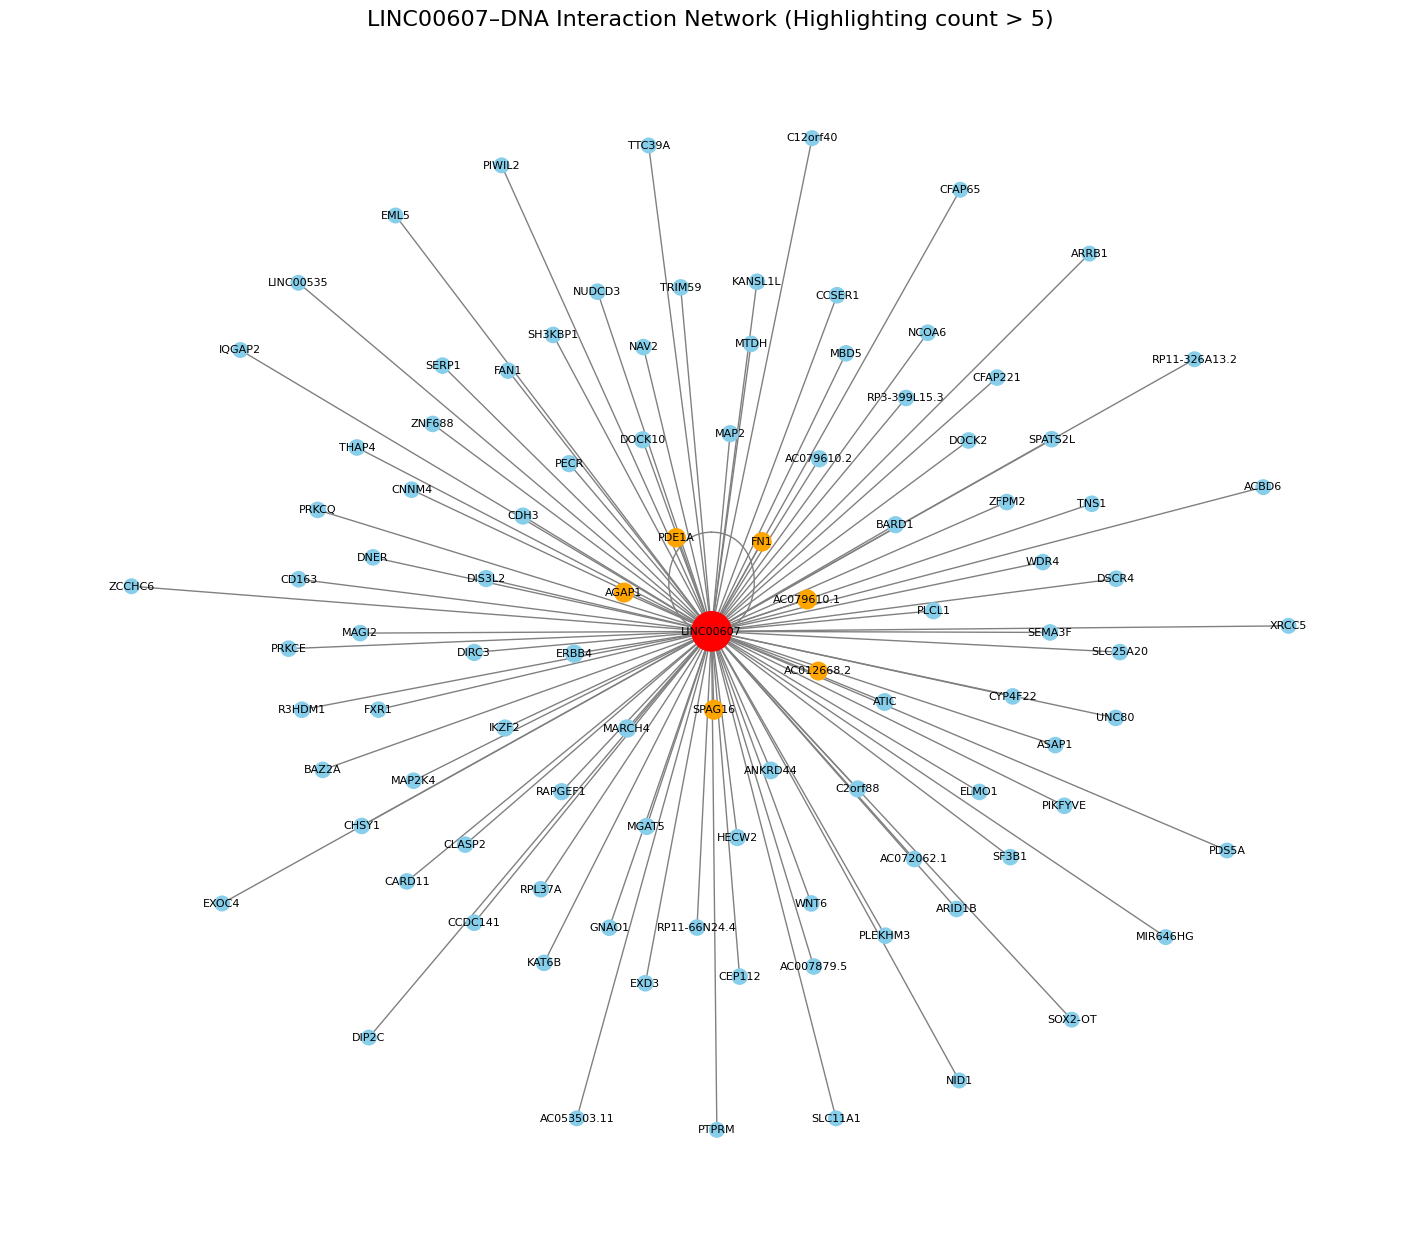

In [108]:
# Set node sizes and colors based on count
node_sizes = []
node_colors = []

for node in G.nodes():
    if node == "LINC00607":
        node_sizes.append(800)
        node_colors.append('red')
    else:
        count = G.nodes[node].get("count", 1)
        node_sizes.append(100 + count * 10)
        # Highlight if count > 5
        if count > 5:
            node_colors.append('orange')  # Highlight color
        else:
            node_colors.append('skyblue')  # Default

# Draw the graph
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=0.6, seed=42)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color='gray',
    font_size=8
)

plt.title("LINC00607–DNA Interaction Network (Highlighting count > 5)", fontsize=16)
plt.axis('off')
plt.show()


In [109]:

vc = linc00607_df['DNA_gene_symbol'].value_counts().reset_index(name='count')
vc.head(5)

,DNA_gene_symbol,count
0,LINC00607,389
1,AGAP1,8
2,SPAG16,8
3,AC079610.1,8
4,PDE1A,7


In [110]:
vc = vc.sort_values(by="count", ascending = False).head(100)

## 3. Putting everything together as a function written in python script

In [115]:
df_9222 = pd.read_csv("./iMARGI_extracted/GSM4729222_HUVEC_control_2_iMARGI.bedpe.gz", sep='\t', comment='#', header=None)

In [118]:
df_9222.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,1,+,-,ENSG00000066279|ASPM|protein_coding,.,ENSG00000066279|ASPM|protein_coding,.,147
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,1,-,-,ENSG00000166225|FRS2|protein_coding,.,ENSG00000141480|ARRB2|protein_coding,.,Inter-chromosome
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,1,-,-,ENSG00000137801|THBS1|protein_coding,.,ENSG00000153339|TRAPPC8|protein_coding,.,Inter-chromosome
3,chr17,21002150,21002214,chr17,21002150,21002214,K00180:743:H2TV7BBXY:6:1101:1205:44939,1,+,-,"ENSG00000124422|USP22|protein_coding,ENSG00000...",.,"ENSG00000124422|USP22|protein_coding,ENSG00000...",.,63


In [119]:
import re

gene_info_cols = []

for col in df_9222.columns:
    sample_values = df_9222[col].dropna().astype(str).head(20)  # sample non-null values
    match_ratio = sum(
        bool(re.match(r'^(?:[^|]*\|){2,}[^|]*$', val)) for val in sample_values
    ) / len(sample_values)

    if match_ratio > 0.7:  # e.g., at least 70% match the pattern
        gene_info_cols.append(col)

print(gene_info_cols)


[10, 12]


In [128]:
df_9222.columns = [
                "RNA_chr", "RNA_start", "RNA_end",
                "DNA_chr", "DNA_start", "DNA_end",
                *df_9222.columns[6:].astype(str)
                ]

In [129]:
df_9222.columns.values[:6]

array(['RNA_chr', 'RNA_start', 'RNA_end', 'DNA_chr', 'DNA_start',
       'DNA_end'], dtype=object)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
import sys
sys.path.append('/content/drive/MyDrive/Z.Chen')


In [1]:
# prompt: mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd /content/drive/MyDrive/Z.Chen

/content/drive/MyDrive/Z.Chen


In [10]:
import coexp_update
import importlib

importlib.reload(coexp_update)
from coexp_update import get_coexp_network_updated

<Figure size 1400x1200 with 0 Axes>

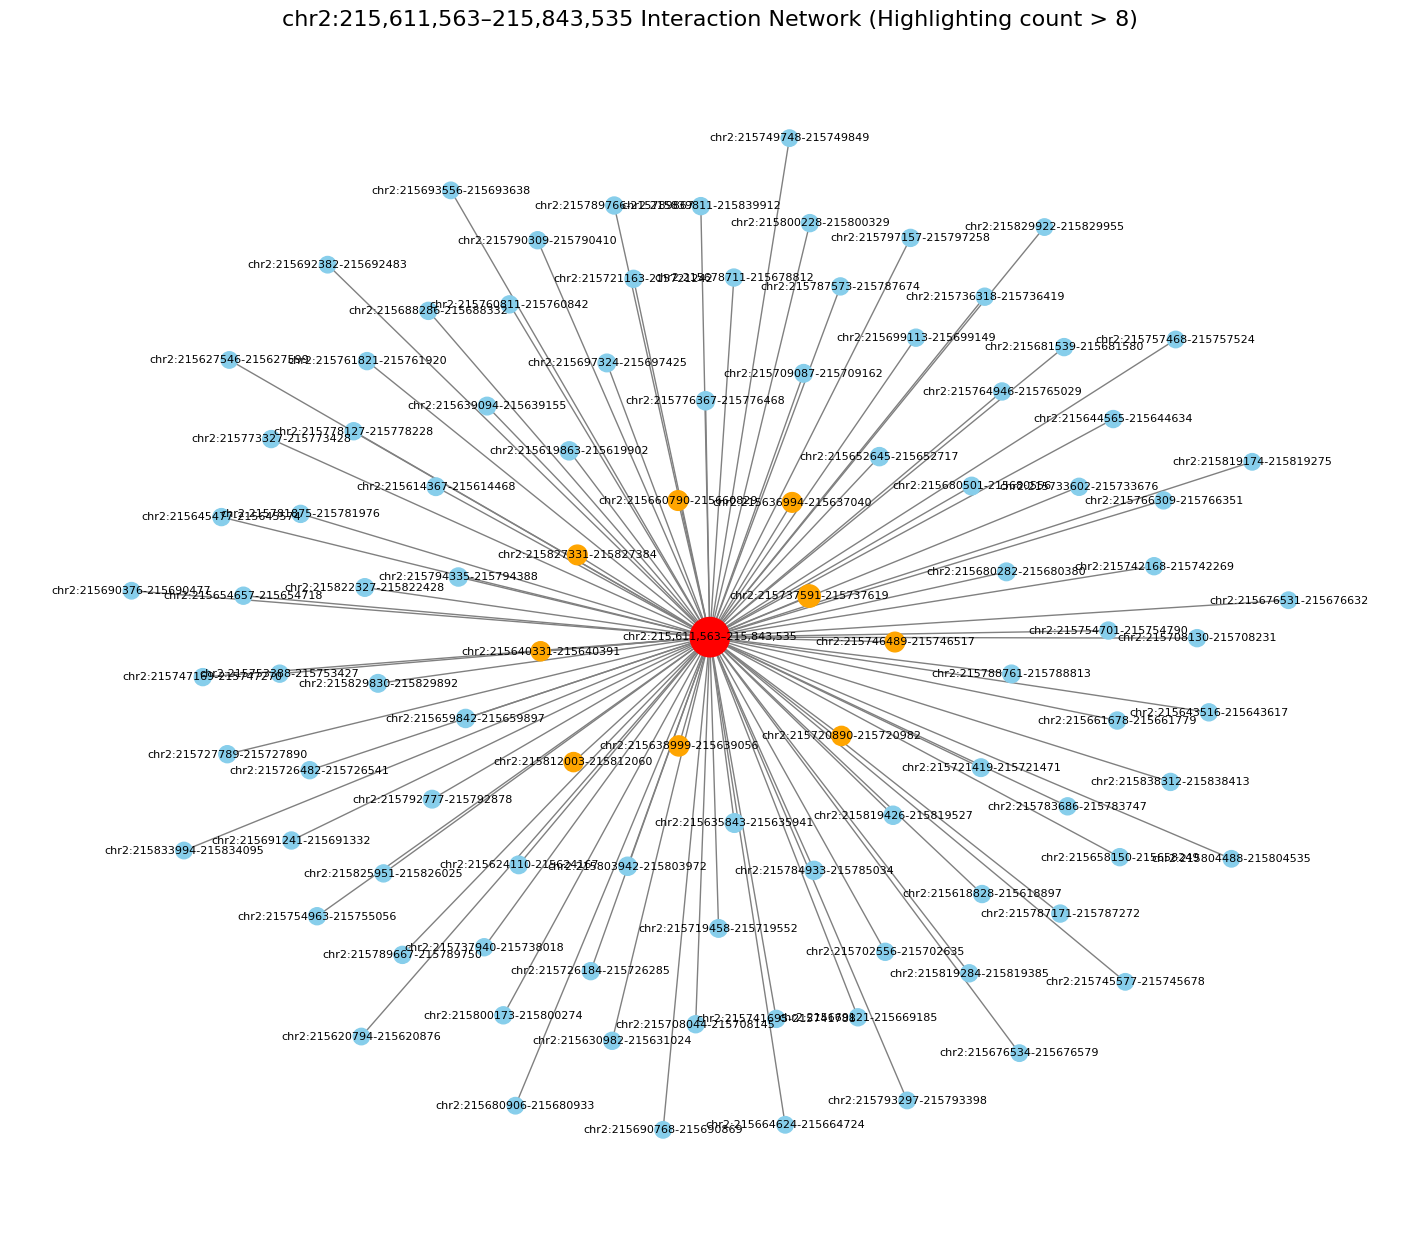

In [11]:
from coexp_update import get_coexp_network_updated
get_coexp_network_updated('chr2:215,611,563–215,843,535', "./iMARGI_extracted/GSM4006840_HUVEC_control_iMARGI.bedpe.gz", 8 )


In [30]:
import re
re.match(r'^chr[\w]+:\d+-\d+$', 'chr2:215,611,563–215,843,535')

In [36]:
"chro3"[:3]

'chr'

In [32]:
print(re.match(r'^chr[\w]+:\d+-\d+$', 'chr2:215,611,563–215,843,535'))

None


In [26]:
coord_candidate = (
        "chr2:215,611,563–215,843,535"
        .replace(',', '')    # strip any thousands‐sep commas
        .replace('–', '-')   # turn en‐dash into ASCII dash
        .replace('—', '-')   # turn em‐dash into ASCII dash
    )

In [27]:
coord_candidate

'chr2:215611563-215843535'

In [6]:
cd /content/drive/MyDrive/Z.Chen/

/content/drive/MyDrive/Z.Chen


In [10]:
ls

GSM4006840_HUVEC_control_iMARGI.bedpe.gz
GSM4006841_HUVEC_H_T3d_iMARGI.bedpe.gz
GSM4006842_HUVEC_H_T7d_iMARGI.bedpe.gz
GSM4729222_HUVEC_control_2_iMARGI.bedpe.gz
GSM4729223_HUVEC_H_T7d_2_iMARGI.bedpe.gz


In [11]:
cd /content/drive/MyDrive/Z.Chen

/content/drive/MyDrive/Z.Chen


In [14]:
df_try = pd.read_csv("./iMARGI_extracted/GSM4729222_HUVEC_control_2_iMARGI.bedpe.gz", sep='\t', comment='#', header=None)

In [15]:
df_try.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,1,+,-,ENSG00000066279|ASPM|protein_coding,.,ENSG00000066279|ASPM|protein_coding,.,147
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,1,-,-,ENSG00000166225|FRS2|protein_coding,.,ENSG00000141480|ARRB2|protein_coding,.,Inter-chromosome
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,1,-,-,ENSG00000137801|THBS1|protein_coding,.,ENSG00000153339|TRAPPC8|protein_coding,.,Inter-chromosome
3,chr17,21002150,21002214,chr17,21002150,21002214,K00180:743:H2TV7BBXY:6:1101:1205:44939,1,+,-,"ENSG00000124422|USP22|protein_coding,ENSG00000...",.,"ENSG00000124422|USP22|protein_coding,ENSG00000...",.,63


In [17]:
df_try.columns = [
            "RNA_chr", "RNA_start", "RNA_end",
            "DNA_chr", "DNA_start", "DNA_end",
            *df_try.columns[6:].astype(str)
            ]

In [18]:
df_try.head(5)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,6,7,8,9,10,11,12,13,14
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,1,+,-,ENSG00000066279|ASPM|protein_coding,.,ENSG00000066279|ASPM|protein_coding,.,147
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,1,-,-,ENSG00000166225|FRS2|protein_coding,.,ENSG00000141480|ARRB2|protein_coding,.,Inter-chromosome
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,1,-,-,ENSG00000137801|THBS1|protein_coding,.,ENSG00000153339|TRAPPC8|protein_coding,.,Inter-chromosome
3,chr17,21002150,21002214,chr17,21002150,21002214,K00180:743:H2TV7BBXY:6:1101:1205:44939,1,+,-,"ENSG00000124422|USP22|protein_coding,ENSG00000...",.,"ENSG00000124422|USP22|protein_coding,ENSG00000...",.,63
4,chr5,72197322,72197421,chr5,72197305,72197406,K00180:743:H2TV7BBXY:6:1101:1205:48667,1,-,+,ENSG00000131711|MAP1B|protein_coding,.,ENSG00000131711|MAP1B|protein_coding,.,83


In [20]:
import re

get_info_col = []

for col in df_try.columns:
  sample_values = df_try[col].dropna().astype(str).head(20)
  match_ratio = sum(
      bool(re.match(r'^(?:[^|]*\|){2,}[^|]*$', val)) for val in sample_values) / len(sample_values)

  if match_ratio > 0.7:
    get_info_col.append(col)

In [21]:
get_info_col

['10', '12']

In [23]:
df_try.rename(
    columns = dict(zip(get_info_col, ["RNA_gene_info", "DNA_gene_info"])),
    inplace = True
)

In [26]:
df_try.head(5)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,RNA_gene_info,DNA_gene_info
0,chr1,197131211,197131310,chr1,197131258,197131359,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding
1,chr12,69551232,69551331,chr17,4715370,4715423,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding
2,chr15,39592565,39592607,chr18,31843437,31843538,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding
3,chr17,21002150,21002214,chr17,21002150,21002214,"ENSG00000124422|USP22|protein_coding,ENSG00000...","ENSG00000124422|USP22|protein_coding,ENSG00000..."
4,chr5,72197322,72197421,chr5,72197305,72197406,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711|MAP1B|protein_coding


In [25]:
df_try = df_try[["RNA_chr", "RNA_start", "RNA_end",
            "DNA_chr", "DNA_start", "DNA_end",
            "RNA_gene_info", "DNA_gene_info"]]

In [30]:
row = df_try[df_try["RNA_gene_info"].str.count(r'\|') == 2]
row['RNA_gene_info']

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,RNA_gene_info,DNA_gene_info
0,chr1,197131211,197131310,chr1,197131258,197131359,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding
1,chr12,69551232,69551331,chr17,4715370,4715423,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding
2,chr15,39592565,39592607,chr18,31843437,31843538,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding
4,chr5,72197322,72197421,chr5,72197305,72197406,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711|MAP1B|protein_coding
5,chr17,3734910,3735009,chr17,3735023,3735124,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457|ITGAE|protein_coding
...,...,...,...,...,...,...,...,...
12594156,chr4,182692656,182692755,chr4,182623731,182623832,ENSG00000218336|TENM3|protein_coding,ENSG00000218336|TENM3|protein_coding
12594157,chr3,58034821,58034904,chr17,28225394,28225495,ENSG00000136068|FLNB|protein_coding,.
12594158,chr11,119295123,119295164,chr2,62442617,62442718,ENSG00000110395|CBL|protein_coding,.
12594159,chr2,55913399,55913444,chr19,40509889,40509951,ENSG00000115380|EFEMP1|protein_coding,ENSG00000160460|SPTBN4|protein_coding


In [37]:
new_row = row[row['DNA_gene_info'].str.count(r'\|') == 2]

In [40]:
new_row['RNA_gene_info'].str.count(r'\|').value_counts()

,count
RNA_gene_info,
2,6836866


In [41]:
new_row['DNA_gene_info'].str.count(r'\|').value_counts()

,count
DNA_gene_info,
2,6836866


In [42]:
ls

6840.png  coexp_update.py    position_info_LINC00607.png  Week1.ipynb
coexp.py  iMARGI_extracted/  __pycache__/                 Week2.ipynb


In [43]:
from coexp_update import get_coexp_network_updated

In [48]:
get_coexp_network_updated('chr1:197131211,197131310', "./iMARGI_extracted/GSM4729222_HUVEC_control_2_iMARGI.bedpe.gz", 5)

no more 10


ValueError: Gene name 'chr1:197131211,197131310' not found in annotated columns.

In [47]:
import coexp_update
import importlib

importlib.reload(coexp_update)
from coexp_update import get_coexp_network_updated

In [50]:
new_row[['RNA_gene_id', 'RNA_gene_symbol', 'RNA_gene_type']] = new_row['RNA_gene_info'].str.split('|', expand=True)
new_row[['DNA_gene_id', 'DNA_gene_symbol', 'DNA_gene_type']] = new_row['DNA_gene_info'].str.split('|', expand=True)


/tmp/ipython-input-50-1492869755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row[['RNA_gene_id', 'RNA_gene_symbol', 'RNA_gene_type']] = new_row['RNA_gene_info'].str.split('|', expand=True)
/tmp/ipython-input-50-1492869755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row[['RNA_gene_id', 'RNA_gene_symbol', 'RNA_gene_type']] = new_row['RNA_gene_info'].str.split('|', expand=True)
/tmp/ipython-input-50-1492869755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [51]:
new_row.head(3)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,RNA_gene_info,DNA_gene_info,RNA_gene_id,RNA_gene_symbol,RNA_gene_type,DNA_gene_id,DNA_gene_symbol,DNA_gene_type
0,chr1,197131211,197131310,chr1,197131258,197131359,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding,ENSG00000066279,ASPM,protein_coding,ENSG00000066279,ASPM,protein_coding
1,chr12,69551232,69551331,chr17,4715370,4715423,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding,ENSG00000166225,FRS2,protein_coding,ENSG00000141480,ARRB2,protein_coding
2,chr15,39592565,39592607,chr18,31843437,31843538,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding,ENSG00000137801,THBS1,protein_coding,ENSG00000153339,TRAPPC8,protein_coding


In [54]:
mtrnr = new_row[new_row['RNA_gene_symbol'] == 'MT-RNR2']

In [58]:
mtrnr.value_counts()

RNA_chr  RNA_start  RNA_end  DNA_chr  DNA_start  DNA_end    RNA_gene_info                    DNA_gene_info                          RNA_gene_id      RNA_gene_symbol  RNA_gene_type  DNA_gene_id      DNA_gene_symbol  DNA_gene_type 
chrM     1669       1752     chrM     1670       1763       ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000210082|MT-RNR2|Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA           154
                    1717     chrM     1670       1717       ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000210082|MT-RNR2|Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA           154
                    1743     chrM     1670       1747       ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000210082|MT-RNR2|Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA           145
                                                 1743       ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000210082|MT-RNR2|Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA           140
         1675       1774     chrM     1670       1771       ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000210082|MT-RNR2|Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000210082  MT-RNR2          Mt_rRNA           127
                                                                                                                                                                                                                                        ... 
         2301       2400     chr19    10709702   10709784   ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000213339|QTRT1|protein_coding   ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000213339  QTRT1            protein_coding      1
                             chr18    9838292    9838393    ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000168461|RAB31|protein_coding   ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000168461  RAB31            protein_coding      1
                                      3472178    3472242    ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000266835|GAPLINC|lincRNA        ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000266835  GAPLINC          lincRNA             1
                             chr17    65966388   65966489   ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000154240|CEP112|protein_coding  ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000154240  CEP112           protein_coding      1
                             chr4     169109155  169109256  ENSG00000210082|MT-RNR2|Mt_rRNA  ENSG00000154447|SH3RF1|protein_coding  ENSG00000210082  MT-RNR2          Mt_rRNA        ENSG00000154447  SH3RF1           protein_coding      1
Name: count, Length: 111086, dtype: int64

In [61]:
new_row.loc[new_row['RNA_gene_symbol']=='MT-RNR2', 'DNA_gene_symbol'].value_counts()

,count
DNA_gene_symbol,
MT-RNR2,51973
NAV2,99
CAMTA1,88
PLXNA4,85
RAD51B,78
...,...
CD164L2,1
EFTUD1P2,1
CLCA4,1


In [62]:
df = mtrnr.loc[mtrnr['RNA_gene_symbol']=='MT-RNR2', 'DNA_gene_symbol'].value_counts()


In [65]:
mtrnr.loc[mtrnr['RNA_gene_symbol']=='MT-RNR2', 'DNA_gene_symbol'].value_counts()

,count
DNA_gene_symbol,
MT-RNR2,51973
NAV2,99
CAMTA1,88
PLXNA4,85
RAD51B,78
...,...
CD164L2,1
EFTUD1P2,1
CLCA4,1


In [67]:
pip install pyranges

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 130.0 MB/s eta 0:00:00


In [157]:
import pyranges as pr

gtf = pr.read_gtf("./gencode.v38.annotation.gtf.gz")


In [159]:
genes = gtf[gtf.Feature == 'gene']

In [160]:
genes = genes[['gene_id', 'gene_name']]

In [161]:
genes

,Chromosome,Start,End,Strand,gene_id,gene_name
0,chr1,11868,14409,+,ENSG00000223972.5,DDX11L1
1,chr1,29553,31109,+,ENSG00000243485.5,MIR1302-2HG
2,chr1,30365,30503,+,ENSG00000284332.1,MIR1302-2
3,chr1,52472,53312,+,ENSG00000268020.3,OR4G4P
4,chr1,57597,64116,+,ENSG00000240361.2,OR4G11P
...,...,...,...,...,...,...
60644,chrY,57015104,57016096,-,ENSG00000237801.6_PAR_Y,AMD1P2
60645,chrY,57165511,57165845,-,ENSG00000228410.6_PAR_Y,ELOCP24
60646,chrY,57171889,57172769,-,ENSG00000223484.7_PAR_Y,TRPC6P
60647,chrY,57201142,57203357,-,ENSG00000185203.12_PAR_Y,WASIR1


In [162]:
genes_df = genes.df

In [163]:
genes_df

,Chromosome,Start,End,Strand,gene_id,gene_name
0,chr1,11868,14409,+,ENSG00000223972.5,DDX11L1
1,chr1,29553,31109,+,ENSG00000243485.5,MIR1302-2HG
2,chr1,30365,30503,+,ENSG00000284332.1,MIR1302-2
3,chr1,52472,53312,+,ENSG00000268020.3,OR4G4P
4,chr1,57597,64116,+,ENSG00000240361.2,OR4G11P
...,...,...,...,...,...,...
60644,chrY,57015104,57016096,-,ENSG00000237801.6_PAR_Y,AMD1P2
60645,chrY,57165511,57165845,-,ENSG00000228410.6_PAR_Y,ELOCP24
60646,chrY,57171889,57172769,-,ENSG00000223484.7_PAR_Y,TRPC6P
60647,chrY,57201142,57203357,-,ENSG00000185203.12_PAR_Y,WASIR1


In [164]:
genes_df = genes_df[['Chromosome', 'Start', 'End','gene_id', 'gene_name']]



In [94]:
genes_df

,Chromosome,Start,End,gene_name
0,chr1,11868,14409,DDX11L1
1,chr1,29553,31109,MIR1302-2HG
2,chr1,30365,30503,MIR1302-2
3,chr1,52472,53312,OR4G4P
4,chr1,57597,64116,OR4G11P
...,...,...,...,...
60644,chrY,57015104,57016096,AMD1P2
60645,chrY,57165511,57165845,ELOCP24
60646,chrY,57171889,57172769,TRPC6P
60647,chrY,57201142,57203357,WASIR1


In [95]:
new_row

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,RNA_gene_info,DNA_gene_info,RNA_gene_id,RNA_gene_symbol,RNA_gene_type,DNA_gene_id,DNA_gene_symbol,DNA_gene_type
0,chr1,197131211,197131310,chr1,197131258,197131359,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding,ENSG00000066279,ASPM,protein_coding,ENSG00000066279,ASPM,protein_coding
1,chr12,69551232,69551331,chr17,4715370,4715423,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding,ENSG00000166225,FRS2,protein_coding,ENSG00000141480,ARRB2,protein_coding
2,chr15,39592565,39592607,chr18,31843437,31843538,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding,ENSG00000137801,THBS1,protein_coding,ENSG00000153339,TRAPPC8,protein_coding
4,chr5,72197322,72197421,chr5,72197305,72197406,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711,MAP1B,protein_coding,ENSG00000131711,MAP1B,protein_coding
5,chr17,3734910,3735009,chr17,3735023,3735124,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457,ITGAE,protein_coding,ENSG00000083457,ITGAE,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12594152,chr1,44518543,44518642,chr1,44518468,44518569,ENSG00000187147|RNF220|protein_coding,ENSG00000187147|RNF220|protein_coding,ENSG00000187147,RNF220,protein_coding,ENSG00000187147,RNF220,protein_coding
12594153,chr3,98793460,98793517,chr9,96777453,96777554,ENSG00000064225|ST3GAL6|protein_coding,ENSG00000081386|ZNF510|protein_coding,ENSG00000064225,ST3GAL6,protein_coding,ENSG00000081386,ZNF510,protein_coding
12594155,chr8,17668200,17668299,chr11,131642238,131642290,ENSG00000129422|MTUS1|protein_coding,ENSG00000182667|NTM|protein_coding,ENSG00000129422,MTUS1,protein_coding,ENSG00000182667,NTM,protein_coding
12594156,chr4,182692656,182692755,chr4,182623731,182623832,ENSG00000218336|TENM3|protein_coding,ENSG00000218336|TENM3|protein_coding,ENSG00000218336,TENM3,protein_coding,ENSG00000218336,TENM3,protein_coding


In [105]:
cd ..

/content/drive/MyDrive/Z.Chen


### Going through as code

In [10]:
cd /content/drive/MyDrive/Z.Chen

/content/drive/MyDrive/Z.Chen


In [11]:
df = pd.read_csv("./iMARGI_extracted/GSM4006840_HUVEC_control_iMARGI.bedpe.gz", sep='\t', comment='#', header=None)

In [13]:
df.head(9)

,0,1,2,3,4,5,6,7,8,9
0,chr4,40944863,40944903,chr4,40944853,40944901,.,.,+,-
1,chr12,53043128,53043227,chr12,53043250,53043351,.,.,+,-
2,chr4,40924463,40924535,chr3,111255038,111255094,.,.,+,-
3,chr1,179100935,179101034,chr1,179100959,179101060,.,.,+,-
4,chr18,61758386,61758485,chr18,61758326,61758427,.,.,-,+
5,chr8,52371188,52371281,chr8,52371189,52371281,.,.,+,-
6,chr12,51995794,51995893,chr12,51995721,51995822,.,.,-,+
7,chr18,12312825,12312868,chr3,196107145,196107241,.,.,-,+
8,chr6,3383092,3383143,chr4,41008298,41008348,.,.,+,+


In [14]:
df.columns = [
            "RNA_chr", "RNA_start", "RNA_end",
            "DNA_chr", "DNA_start", "DNA_end",
            "name", "score", "RNA_strand", "DNA_strand"
        ]


In [12]:
df.head(3)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand
0,chr4,40944863,40944903,chr4,40944853,40944901,.,.,+,-
1,chr12,53043128,53043227,chr12,53043250,53043351,.,.,+,-
2,chr4,40924463,40924535,chr3,111255038,111255094,.,.,+,-


In [182]:
genes = pd.read_csv("/content/drive/MyDrive/Z.Chen/genes_df.csv")

In [21]:
#rna annotation

rna_annot = genes.rename(columns={
    'Chromosome':"RNA_chr",
    'Start'     : "RNA_start",
    'End'       : "RNA_end",
    'gene_name' :'RNA_gene_name'
})

df = df.merge(rna_annot,
              how='left',
              on = ['RNA_chr', 'RNA_start', 'RNA_end'])

In [26]:
df['RNA_gene_name'].value_counts()

,count
RNA_gene_name,
SNORD26,225
RNU7-1,197
SNORD14E,186
SNORD58C,146
SNORD60,138
...,...
SNORD57,1
RP11-57C19.8,1
SNORD53B,1


In [27]:
#dna annotation

dna_annot = genes.rename(columns={
    'Chromosome':"DNA_chr",
    'Start'     : "DNA_start",
    'End'       : "DNA_end",
    'gene_name' :'DNA_gene_name'
})


df = df.merge(dna_annot,
              how='left',
              on = ['DNA_chr', 'DNA_start', 'DNA_end'])

In [28]:
genes

,Chromosome,Start,End,gene_name
0,chr1,11868,14409,DDX11L1
1,chr1,29553,31109,MIR1302-2HG
2,chr1,30365,30503,MIR1302-2
3,chr1,52472,53312,OR4G4P
4,chr1,57597,64116,OR4G11P
...,...,...,...,...
60644,chrY,57015104,57016096,AMD1P2
60645,chrY,57165511,57165845,ELOCP24
60646,chrY,57171889,57172769,TRPC6P
60647,chrY,57201142,57203357,WASIR1


In [29]:
genes[genes['gene_name']=='LINC00607']

,Chromosome,Start,End,gene_name
9395,chr2,215611562,215848954,LINC00607


In [30]:
df.head(3)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand,RNA_gene_name,DNA_gene_name
0,chr4,40944863,40944903,chr4,40944853,40944901,.,.,+,-,NaN,NaN
1,chr12,53043128,53043227,chr12,53043250,53043351,.,.,+,-,NaN,NaN
2,chr4,40924463,40924535,chr3,111255038,111255094,.,.,+,-,NaN,NaN


In [31]:
df.DNA_gene_name.value_counts()

,count
DNA_gene_name,
SNORD14E,109
SNORD49A,108
SNORD60,101
MT-TM,99
MT-TV,94
...,...
SNORD116-21,1
SNORD18C,1
SNORD30,1


In [42]:
df.head(3)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand,RNA_gene_name,DNA_gene_name
0,chr4,40944863,40944903,chr4,40944853,40944901,.,.,+,-,NaN,NaN
1,chr12,53043128,53043227,chr12,53043250,53043351,.,.,+,-,NaN,NaN
2,chr4,40924463,40924535,chr3,111255038,111255094,.,.,+,-,NaN,NaN


In [44]:
# chr2: 215611563 - 215,843,535

query_df = df[(df['RNA_chr'] == 'chr2') &
            (df['RNA_start'] <= 215843535) &
            (df['RNA_end'] >= 215611563)
            ]
query_df


,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand,RNA_gene_name,DNA_gene_name
6708,chr2,215657129,215657226,chr2,222636600,222636701,.,.,+,-,NaN,NaN
10525,chr2,215841155,215841254,chr2,215841208,215841309,.,.,+,-,NaN,NaN
16031,chr2,215696327,215696426,chr2,215696340,215696441,.,.,+,-,NaN,NaN
18787,chr2,215670740,215670824,chr2,215670740,215670823,.,.,+,-,NaN,NaN
21502,chr2,215622700,215622766,chr2,215622694,215622774,.,.,+,-,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
66242666,chr2,215756288,215756377,chr2,215756288,215756377,.,.,+,-,NaN,NaN
66243924,chr2,215654402,215654498,chr2,215654398,215654498,.,.,+,-,NaN,NaN
66245860,chr2,215674836,215674935,chr4,173060027,173060074,.,.,+,+,NaN,NaN
66251117,chr2,215721748,215721847,chr12,116284734,116284829,.,.,+,+,NaN,NaN


In [46]:
query_df.value_counts().reset_index(name='count')

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand,RNA_gene_name,DNA_gene_name,count


In [166]:
genes_df[genes_df['gene_id']== 'ENSG00000235770']

,Chromosome,Start,End,gene_id,gene_name


In [167]:
df.head(3)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand,RNA_gene_name
0,chr4,40944863,40944903,chr4,40944853,40944901,.,.,+,-,NaN
1,chr12,53043128,53043227,chr12,53043250,53043351,.,.,+,-,NaN
2,chr4,40924463,40924535,chr3,111255038,111255094,.,.,+,-,NaN


chr2:215,611,563–215,843,535

In [26]:
df.head(3)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand,RNA_gene_name,DNA_gene_name
0,chr4,40944863,40944903,chr4,40944853,40944901,.,.,+,-,NaN,NaN
1,chr12,53043128,53043227,chr12,53043250,53043351,.,.,+,-,NaN,NaN
2,chr4,40924463,40924535,chr3,111255038,111255094,.,.,+,-,NaN,NaN


,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand,RNA_gene_name,DNA_gene_name


In [27]:
query_df = df[(df['RNA_chr'] == 'chr2') &
            (df['RNA_start'] <=  215843535) &
            (df['RNA_end'] >= 215611563)]

In [58]:
query_df['DNA_coord'] = (
    query_df['DNA_chr'].astype(str)
    + ':'
    + query_df['DNA_start'].astype(str)
    + '-'
    + query_df['DNA_end'].astype(str)
)

query_df.head(3)

/tmp/ipython-input-58-1494534861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df['DNA_coord'] = (


,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,name,score,RNA_strand,DNA_strand,RNA_gene_name,DNA_gene_name,DNA_coord
6708,chr2,215657129,215657226,chr2,222636600,222636701,.,.,+,-,NaN,NaN,chr2:222636600-222636701
10525,chr2,215841155,215841254,chr2,215841208,215841309,.,.,+,-,NaN,NaN,chr2:215841208-215841309
16031,chr2,215696327,215696426,chr2,215696340,215696441,.,.,+,-,NaN,NaN,chr2:215696340-215696441


In [60]:
vc = query_df[['RNA_chr', 'DNA_coord']].value_counts().reset_index(name='count')

vc = vc.sort_values(by='count', ascending=False).head(100)


vc

,RNA_chr,DNA_coord,count
0,chr2,chr2:215737591-215737619,16
1,chr2,chr2:215638999-215639056,11
5,chr2,chr2:215636994-215637040,10
2,chr2,chr2:215762486-215762584,10
4,chr2,chr2:215746489-215746517,10
...,...,...,...
97,chr2,chr2:215503631-215503732,5
96,chr2,chr2:8849479-8849571,5
127,chr2,chr2:221668549-221668599,5
126,chr2,chr2:215781875-215781976,5


In [62]:
for _, row in vc.iterrows():
    print(row['count'])

16
11
10
10
10
10
10
9
9
9
9
9
8
8
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [79]:
print('SNORD26' in df['RNA_gene_name'].values)

True


In [85]:
query_df = df[df['RNA_gene_name']=='SNORD26'][['RNA_gene_name', 'DNA_gene_name']]
query_df.value_counts()

,,count
RNA_gene_name,DNA_gene_name,
SNORD26,SNORD26,52


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
genes = pd.read_csv("/content/drive/MyDrive/Z.Chen/genes_df.csv")

In [86]:
ls

6840.png                       genes_df.csv                 Week1.ipynb
coexp.py                       iMARGI_extracted/            Week2.ipynb
coexp_update.py                position_info_LINC00607.png
gencode.v38.annotation.gtf.gz  __pycache__/


In [87]:
cd /content/drive/MyDrive/Z.Chen/iMARGI_extracted/

/content/drive/MyDrive/Z.Chen/iMARGI_extracted


In [88]:
ls

GSM4006840_HUVEC_control_iMARGI.bedpe.gz
GSM4006841_HUVEC_H_T3d_iMARGI.bedpe.gz
GSM4006842_HUVEC_H_T7d_iMARGI.bedpe.gz
GSM4729222_HUVEC_control_2_iMARGI.bedpe.gz
GSM4729223_HUVEC_H_T7d_2_iMARGI.bedpe.gz


In [89]:
cd /content/drive/MyDrive/Z.Chen/

/content/drive/MyDrive/Z.Chen


In [90]:
df = pd.read_csv("./iMARGI_extracted/GSM4729222_HUVEC_control_2_iMARGI.bedpe.gz", sep='\t', comment='#', header=None)

In [91]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,1,+,-,ENSG00000066279|ASPM|protein_coding,.,ENSG00000066279|ASPM|protein_coding,.,147
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,1,-,-,ENSG00000166225|FRS2|protein_coding,.,ENSG00000141480|ARRB2|protein_coding,.,Inter-chromosome
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,1,-,-,ENSG00000137801|THBS1|protein_coding,.,ENSG00000153339|TRAPPC8|protein_coding,.,Inter-chromosome


In [94]:
import re

gene_info_cols = []

for col in df.columns:
            sample_values = df[col].dropna().astype(str).head(20)

            match_ratio = sum(
                bool(re.match(r'^(?:[^|]*\|){2,}[^|]*$', val)) for val in sample_values
            ) / len(sample_values)

            # setting the matchin pattern to be
            # at least 70% matching
            if match_ratio > 0.7:
                gene_info_cols.append(col)

In [96]:
df.rename(
            columns=dict(zip(gene_info_cols, ["RNA_gene_info", "DNA_gene_info"])),
            inplace=True
            )

df.head(3)

,0,1,2,3,4,5,6,7,8,9,RNA_gene_info,11,DNA_gene_info,13,14
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,1,+,-,ENSG00000066279|ASPM|protein_coding,.,ENSG00000066279|ASPM|protein_coding,.,147
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,1,-,-,ENSG00000166225|FRS2|protein_coding,.,ENSG00000141480|ARRB2|protein_coding,.,Inter-chromosome
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,1,-,-,ENSG00000137801|THBS1|protein_coding,.,ENSG00000153339|TRAPPC8|protein_coding,.,Inter-chromosome


In [97]:
df.columns = [
            "RNA_chr", "RNA_start", "RNA_end",
            "DNA_chr", "DNA_start", "DNA_end",
            *df.columns[6:].astype(str)
            ]

df.head(3)

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,6,7,8,9,RNA_gene_info,11,DNA_gene_info,13,14
0,chr1,197131211,197131310,chr1,197131258,197131359,K00180:743:H2TV7BBXY:6:1101:1205:32103,1,+,-,ENSG00000066279|ASPM|protein_coding,.,ENSG00000066279|ASPM|protein_coding,.,147
1,chr12,69551232,69551331,chr17,4715370,4715423,K00180:743:H2TV7BBXY:6:1101:1205:32279,1,-,-,ENSG00000166225|FRS2|protein_coding,.,ENSG00000141480|ARRB2|protein_coding,.,Inter-chromosome
2,chr15,39592565,39592607,chr18,31843437,31843538,K00180:743:H2TV7BBXY:6:1101:1205:37343,1,-,-,ENSG00000137801|THBS1|protein_coding,.,ENSG00000153339|TRAPPC8|protein_coding,.,Inter-chromosome


In [98]:
df = df[["RNA_chr", "RNA_start", "RNA_end",
            "DNA_chr", "DNA_start", "DNA_end",
            "RNA_gene_info", "DNA_gene_info"]]

In [100]:
df_rna_filtered = df[df['RNA_gene_info'].str.count(r'\|')==2]
df_all_filtered = df_rna_filtered[df_rna_filtered['DNA_gene_info'].str.count(r'\|') == 2]

In [101]:
df = df_all_filtered
df

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,RNA_gene_info,DNA_gene_info
0,chr1,197131211,197131310,chr1,197131258,197131359,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding
1,chr12,69551232,69551331,chr17,4715370,4715423,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding
2,chr15,39592565,39592607,chr18,31843437,31843538,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding
4,chr5,72197322,72197421,chr5,72197305,72197406,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711|MAP1B|protein_coding
5,chr17,3734910,3735009,chr17,3735023,3735124,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457|ITGAE|protein_coding
...,...,...,...,...,...,...,...,...
12594152,chr1,44518543,44518642,chr1,44518468,44518569,ENSG00000187147|RNF220|protein_coding,ENSG00000187147|RNF220|protein_coding
12594153,chr3,98793460,98793517,chr9,96777453,96777554,ENSG00000064225|ST3GAL6|protein_coding,ENSG00000081386|ZNF510|protein_coding
12594155,chr8,17668200,17668299,chr11,131642238,131642290,ENSG00000129422|MTUS1|protein_coding,ENSG00000182667|NTM|protein_coding
12594156,chr4,182692656,182692755,chr4,182623731,182623832,ENSG00000218336|TENM3|protein_coding,ENSG00000218336|TENM3|protein_coding


In [102]:
df[['RNA_gene_id', 'RNA_gene_symbol', 'RNA_gene_type']] = df['RNA_gene_info'].str.split('|', expand=True)
df[['DNA_gene_id', 'DNA_gene_symbol', 'DNA_gene_type']] = df['DNA_gene_info'].str.split('|', expand=True)

/tmp/ipython-input-102-3574265966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['RNA_gene_id', 'RNA_gene_symbol', 'RNA_gene_type']] = df['RNA_gene_info'].str.split('|', expand=True)
/tmp/ipython-input-102-3574265966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['RNA_gene_id', 'RNA_gene_symbol', 'RNA_gene_type']] = df['RNA_gene_info'].str.split('|', expand=True)
/tmp/ipython-input-102-3574265966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [106]:
df

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,RNA_gene_info,DNA_gene_info,RNA_gene_id,RNA_gene_symbol,RNA_gene_type,DNA_gene_id,DNA_gene_symbol,DNA_gene_type
0,chr1,197131211,197131310,chr1,197131258,197131359,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding,ENSG00000066279,ASPM,protein_coding,ENSG00000066279,ASPM,protein_coding
1,chr12,69551232,69551331,chr17,4715370,4715423,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding,ENSG00000166225,FRS2,protein_coding,ENSG00000141480,ARRB2,protein_coding
2,chr15,39592565,39592607,chr18,31843437,31843538,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding,ENSG00000137801,THBS1,protein_coding,ENSG00000153339,TRAPPC8,protein_coding
4,chr5,72197322,72197421,chr5,72197305,72197406,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711,MAP1B,protein_coding,ENSG00000131711,MAP1B,protein_coding
5,chr17,3734910,3735009,chr17,3735023,3735124,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457,ITGAE,protein_coding,ENSG00000083457,ITGAE,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12594152,chr1,44518543,44518642,chr1,44518468,44518569,ENSG00000187147|RNF220|protein_coding,ENSG00000187147|RNF220|protein_coding,ENSG00000187147,RNF220,protein_coding,ENSG00000187147,RNF220,protein_coding
12594153,chr3,98793460,98793517,chr9,96777453,96777554,ENSG00000064225|ST3GAL6|protein_coding,ENSG00000081386|ZNF510|protein_coding,ENSG00000064225,ST3GAL6,protein_coding,ENSG00000081386,ZNF510,protein_coding
12594155,chr8,17668200,17668299,chr11,131642238,131642290,ENSG00000129422|MTUS1|protein_coding,ENSG00000182667|NTM|protein_coding,ENSG00000129422,MTUS1,protein_coding,ENSG00000182667,NTM,protein_coding
12594156,chr4,182692656,182692755,chr4,182623731,182623832,ENSG00000218336|TENM3|protein_coding,ENSG00000218336|TENM3|protein_coding,ENSG00000218336,TENM3,protein_coding,ENSG00000218336,TENM3,protein_coding


In [118]:
# chr2:215,611,563–215,843,535


query_df = df[(df['RNA_chr'] == 'chr2') &
            (df['RNA_start'] <= 215843535) &
            (df['RNA_end'] >= 215611563)
            ]

query_df

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,RNA_gene_info,DNA_gene_info,RNA_gene_id,RNA_gene_symbol,RNA_gene_type,DNA_gene_id,DNA_gene_symbol,DNA_gene_type
14455,chr2,215744103,215744190,chr2,216283729,216283807,ENSG00000235770|LINC00607|lincRNA,ENSG00000144583|MARCH4|protein_coding,ENSG00000235770,LINC00607,lincRNA,ENSG00000144583,MARCH4,protein_coding
30147,chr2,215755772,215755871,chr2,218382892,218382993,ENSG00000235770|LINC00607|lincRNA,ENSG00000018280|SLC11A1|protein_coding,ENSG00000235770,LINC00607,lincRNA,ENSG00000018280,SLC11A1,protein_coding
47199,chr2,215817776,215817875,chr2,215766067,215766168,ENSG00000235770|LINC00607|lincRNA,ENSG00000235770|LINC00607|lincRNA,ENSG00000235770,LINC00607,lincRNA,ENSG00000235770,LINC00607,lincRNA
78956,chr2,215739918,215740017,chr8,22311980,22312072,ENSG00000235770|LINC00607|lincRNA,ENSG00000197181|PIWIL2|protein_coding,ENSG00000235770,LINC00607,lincRNA,ENSG00000197181,PIWIL2,protein_coding
82933,chr2,215757241,215757304,chr18,7808976,7809077,ENSG00000235770|LINC00607|lincRNA,ENSG00000173482|PTPRM|protein_coding,ENSG00000235770,LINC00607,lincRNA,ENSG00000173482,PTPRM,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12548083,chr2,215796619,215796718,chr2,215796780,215796881,ENSG00000235770|LINC00607|lincRNA,ENSG00000235770|LINC00607|lincRNA,ENSG00000235770,LINC00607,lincRNA,ENSG00000235770,LINC00607,lincRNA
12559287,chr2,215743703,215743802,chr2,215743772,215743873,ENSG00000235770|LINC00607|lincRNA,ENSG00000235770|LINC00607|lincRNA,ENSG00000235770,LINC00607,lincRNA,ENSG00000235770,LINC00607,lincRNA
12561013,chr2,215729245,215729293,chr11,62376205,62376306,ENSG00000235770|LINC00607|lincRNA,ENSG00000162174|ASRGL1|protein_coding,ENSG00000235770,LINC00607,lincRNA,ENSG00000162174,ASRGL1,protein_coding
12575403,chr2,215823608,215823701,chr9,86341869,86341970,ENSG00000235770|LINC00607|lincRNA,ENSG00000083223|ZCCHC6|protein_coding,ENSG00000235770,LINC00607,lincRNA,ENSG00000083223,ZCCHC6,protein_coding


In [119]:
query_df = query_df['DNA_gene_symbol']
query_df

,DNA_gene_symbol
14455,MARCH4
30147,SLC11A1
47199,LINC00607
78956,PIWIL2
82933,PTPRM
...,...
12548083,LINC00607
12559287,LINC00607
12561013,ASRGL1
12575403,ZCCHC6


In [120]:
query_df.value_counts()

,count
DNA_gene_symbol,
LINC00607,389
AC079610.1,8
AGAP1,8
SPAG16,8
PDE1A,7
...,...
KLHL29,1
RP11-1049H7.2,1
LINC00836,1


In [121]:
df

,RNA_chr,RNA_start,RNA_end,DNA_chr,DNA_start,DNA_end,RNA_gene_info,DNA_gene_info,RNA_gene_id,RNA_gene_symbol,RNA_gene_type,DNA_gene_id,DNA_gene_symbol,DNA_gene_type
0,chr1,197131211,197131310,chr1,197131258,197131359,ENSG00000066279|ASPM|protein_coding,ENSG00000066279|ASPM|protein_coding,ENSG00000066279,ASPM,protein_coding,ENSG00000066279,ASPM,protein_coding
1,chr12,69551232,69551331,chr17,4715370,4715423,ENSG00000166225|FRS2|protein_coding,ENSG00000141480|ARRB2|protein_coding,ENSG00000166225,FRS2,protein_coding,ENSG00000141480,ARRB2,protein_coding
2,chr15,39592565,39592607,chr18,31843437,31843538,ENSG00000137801|THBS1|protein_coding,ENSG00000153339|TRAPPC8|protein_coding,ENSG00000137801,THBS1,protein_coding,ENSG00000153339,TRAPPC8,protein_coding
4,chr5,72197322,72197421,chr5,72197305,72197406,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711|MAP1B|protein_coding,ENSG00000131711,MAP1B,protein_coding,ENSG00000131711,MAP1B,protein_coding
5,chr17,3734910,3735009,chr17,3735023,3735124,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457|ITGAE|protein_coding,ENSG00000083457,ITGAE,protein_coding,ENSG00000083457,ITGAE,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12594152,chr1,44518543,44518642,chr1,44518468,44518569,ENSG00000187147|RNF220|protein_coding,ENSG00000187147|RNF220|protein_coding,ENSG00000187147,RNF220,protein_coding,ENSG00000187147,RNF220,protein_coding
12594153,chr3,98793460,98793517,chr9,96777453,96777554,ENSG00000064225|ST3GAL6|protein_coding,ENSG00000081386|ZNF510|protein_coding,ENSG00000064225,ST3GAL6,protein_coding,ENSG00000081386,ZNF510,protein_coding
12594155,chr8,17668200,17668299,chr11,131642238,131642290,ENSG00000129422|MTUS1|protein_coding,ENSG00000182667|NTM|protein_coding,ENSG00000129422,MTUS1,protein_coding,ENSG00000182667,NTM,protein_coding
12594156,chr4,182692656,182692755,chr4,182623731,182623832,ENSG00000218336|TENM3|protein_coding,ENSG00000218336|TENM3|protein_coding,ENSG00000218336,TENM3,protein_coding,ENSG00000218336,TENM3,protein_coding


In [126]:
query_df = df[df['RNA_gene_symbol'] == 'LINC00607'][['DNA_gene_symbol']]

query_df

,DNA_gene_symbol
14455,MARCH4
30147,SLC11A1
47199,LINC00607
78956,PIWIL2
82933,PTPRM
...,...
12548083,LINC00607
12559287,LINC00607
12561013,ASRGL1
12575403,ZCCHC6


In [127]:
query_df.value_counts()

,count
DNA_gene_symbol,
LINC00607,389
SPAG16,8
AGAP1,8
AC079610.1,8
FN1,7
...,...
VWA7,1
WDFY1,1
WDR12,1


In [128]:
import coexp_update
import importlib
importlib.reload(coexp_update)

# and then re‐import whatever names you need:
from coexp_update import get_coexp_network_updated

'/content/drive/MyDrive/Z.Chen'

In [133]:
get_coexp_network_updated('LINC00607', './iMARGI_extracted/GSM4006841_HUVEC_H_T3d_iMARGI.bedpe.gz', 6)

Sorry, gene name LINC00607 not found in dataset.


UnboundLocalError: cannot access local variable 'G' where it is not associated with a value

<Figure size 1400x1200 with 0 Axes>